# Creates classifier based on clusters occurance

## Imports and constants

In [67]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
import pickle
from get_orlov_datasets import get_orlov_datasets
from autoencoder import Autoencoder, Encoder, Decoder
from torchvision.transforms.functional import crop
from torch.utils.data import DataLoader, TensorDataset

In [98]:
SUBIMAGE_SIZE = 40
BATCH_SIZE = 256
NUM_LOADERS_WORKERS = 0
PRETRAINED_AUTOENCODER_FILE = './checkpoints/autoencoder/old/ldim-256_c_hid-32_lam-50-decoder_extended-3/checkpoints/epoch=14-step=570.ckpt'
# PRETRAINED_AUTOENCODER_FILE = 'C:/_DIPLOMA/code/checkpoints/autoenc4_test/lightning_logs/ldim-256_c_hid-32_lam-50-decoder_extended-3/checkpoints/epoch=14-step=570.ckpt'
TRAINED_KMEANS_FILE = './checkpoints/kmeans/v1_KMeans.pkl'
CENTROIDS_COUNT=48
EPOCHS_NUM = 200

## Load data and models

In [69]:
train_loader, val_loader, test_loader, additional = get_orlov_datasets(train_subimages_num=1, 
                                                                        num_loaders_workers=NUM_LOADERS_WORKERS,
                                                                        batch_size=1, subimage_size=None)

In [70]:
data_train, data_test, train_count, val_count, test_count = additional

In [71]:
autoencoder_model = Autoencoder.load_from_checkpoint(PRETRAINED_AUTOENCODER_FILE)
encoder = Encoder(num_input_channels=3, base_channel_size=32, latent_dim=256)
encoder.load_state_dict(autoencoder_model.encoder.state_dict())

<All keys matched successfully>

In [72]:
file = open(TRAINED_KMEANS_FILE, 'rb')
kmeans: KMeans = pickle.load(file)

C:\Users\Andrii\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator KMeans from version 1.2.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [73]:
train_xs = np.zeros((train_count, CENTROIDS_COUNT))
val_xs = np.zeros((val_count, CENTROIDS_COUNT))
test_xs = np.zeros((test_count, CENTROIDS_COUNT))
train_ys, val_ys, test_ys = np.zeros((train_count, 1)), np.zeros((val_count, 1)), np.zeros((test_count, 1))

## Using kmeans and encoder to create classifier

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
encoder = encoder.to(device)

In [76]:
def occs_dataset(loader, data, xs, ys):
    i = 0
    for batch_images, batch_classes in tqdm(loader):
        image = batch_images[0]

        subimages_batch, reconstruction_info = data.get_pure_image_subimages(image)

        width_count, height_count = reconstruction_info[3], reconstruction_info[2]

        subimages_batch = subimages_batch.to(device)
        with torch.no_grad():
            representations = encoder(subimages_batch)
        reps_np = representations.cpu().detach().numpy()

        reps_clusters = kmeans.predict(reps_np)
        images_count = width_count * height_count

        xs[i] = np.bincount(reps_clusters, minlength=CENTROIDS_COUNT) / images_count
        ys[i] = batch_classes[0]
        i += 1

In [77]:
occs_dataset(train_loader, data_train.datasets[0], train_xs, train_ys)

100%|██████████| 300/300 [03:09<00:00,  1.58it/s]


In [78]:
occs_dataset(val_loader, data_train.datasets[0], val_xs, val_ys)
occs_dataset(test_loader, data_train.datasets[0], test_xs, test_ys)

100%|██████████| 33/33 [00:21<00:00,  1.54it/s]


In [79]:
train_dataset = TensorDataset(torch.Tensor(train_xs), torch.Tensor(train_ys))
test_dataset = TensorDataset(torch.Tensor(test_xs), torch.Tensor(test_ys))
val_dataset = TensorDataset(torch.Tensor(val_xs), torch.Tensor(val_ys))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_LOADERS_WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_LOADERS_WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_LOADERS_WORKERS)

In [143]:
class SimpleClassifier(nn.Module):
    def __init__(self, clusters_count: int, outputs_count: int = 3):
        super().__init__()
        self.clusters_count = clusters_count
        self.outputs_count = outputs_count

        self.classifier = nn.Sequential(
            nn.Linear(clusters_count, 32),
            nn.ReLU(),
            nn.Linear(32, 12),
            nn.ReLU(),
            nn.Linear(12, outputs_count),
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [144]:
model = SimpleClassifier(clusters_count=48)
model = model.to(device)

In [145]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5)

In [146]:
best_val_loss = np.inf
train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_precs, val_precs = [], []
train_recalls, val_recalls = [], []

In [147]:
for epoch in range(EPOCHS_NUM):
    epoch_loss = 0.0
    epoch_acc = 0.0
    epoch_precision = 0.0
    epoch_recall = 0.0
    # epoch_roc_auc = 0.0
    images_count = 0

    print(f'EPOCH {epoch + 1}')

    model.train()
    for images_reps, class_idxs in train_dataloader:
        images_reps = images_reps.to(device)
        batch_size = images_reps.size()[0]
        class_idxs = class_idxs.squeeze().long()
        class_idxs = class_idxs.to(device)

        optimizer.zero_grad()

        output = model(images_reps)

        loss = criterion(output, class_idxs)

        loss.backward()
        optimizer.step()

        output_labels = torch.argmax(output, dim=1).cpu().detach().numpy()
        class_idxs_np = class_idxs.cpu().numpy()

        batch_accuracy = accuracy_score(class_idxs_np, output_labels)
        batch_precision = precision_score(class_idxs_np, output_labels, average='macro', zero_division=0)
        batch_recall = recall_score(class_idxs_np, output_labels, average='macro', zero_division=0)

        images_count += batch_size
        epoch_acc += batch_accuracy * batch_size
        epoch_precision += batch_precision * batch_size
        epoch_recall += batch_recall * batch_size

        epoch_loss += loss.item() * batch_size

    epoch_loss = epoch_loss / images_count
    epoch_acc = epoch_acc / images_count
    epoch_precision = epoch_precision / images_count
    epoch_recall = epoch_recall / images_count

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    train_precs.append(epoch_precision)
    train_recalls.append(epoch_recall)

    print(f"Training loss: {epoch_loss:.4f}, accuracy: {epoch_acc:.4f}, precision: {epoch_precision:.4f}, recall: {epoch_recall:.4f}")
    
    val_loss = 0
    images_count = 0
    val_acc = 0
    val_precision = 0
    val_recall = 0
    model.eval()    
    
    for images_reps, class_idxs in val_dataloader:
        with torch.no_grad():
            images_reps = images_reps.to(device)
            batch_size = images_reps.size()[0]
            class_idxs = class_idxs.squeeze().long()
            class_idxs = class_idxs.to(device)

            output = model(images_reps)

            loss = criterion(output, class_idxs)              

            val_loss += loss.item() * batch_size
            images_count += batch_size

            output_labels = torch.argmax(output, dim=1).cpu().detach().numpy()
            class_idxs_np = class_idxs.cpu().numpy()

            batch_accuracy = accuracy_score(class_idxs_np, output_labels)
            batch_precision = precision_score(class_idxs_np, output_labels, average='macro', zero_division=0)
            batch_recall = recall_score(class_idxs_np, output_labels, average='macro', zero_division=0)

            val_acc += batch_accuracy * batch_size
            val_precision += batch_precision * batch_size
            val_recall += batch_recall * batch_size

    val_loss = val_loss / images_count
    val_acc = val_acc / images_count
    val_precision = val_precision / images_count
    val_recall = val_recall / images_count
    scheduler.step(val_loss)

    print(f'Validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}, precision: {val_precision:.4f}, recall: {val_recall:.4f}')
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_precs.append(val_precision)
    val_recalls.append(val_recall)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"./checkpoints/classifier/simple_classifer_clustering.pt")
        print("Saved state dict!")
    print()

EPOCH 1
Training loss: 1.1184, accuracy: 0.3300, precision: 0.1100, recall: 0.3333
Validation loss: 1.1384, accuracy: 0.2927, precision: 0.0976, recall: 0.3333
Saved state dict!

EPOCH 2
Training loss: 1.1172, accuracy: 0.3300, precision: 0.1100, recall: 0.3333
Validation loss: 1.1369, accuracy: 0.2927, precision: 0.0976, recall: 0.3333
Saved state dict!

EPOCH 3
Training loss: 1.1160, accuracy: 0.3300, precision: 0.1100, recall: 0.3333
Validation loss: 1.1354, accuracy: 0.2927, precision: 0.0976, recall: 0.3333
Saved state dict!

EPOCH 4
Training loss: 1.1149, accuracy: 0.3300, precision: 0.1100, recall: 0.3333
Validation loss: 1.1340, accuracy: 0.2927, precision: 0.0976, recall: 0.3333
Saved state dict!

EPOCH 5
Training loss: 1.1138, accuracy: 0.3300, precision: 0.1100, recall: 0.3333
Validation loss: 1.1325, accuracy: 0.2927, precision: 0.0976, recall: 0.3333
Saved state dict!

EPOCH 6
Training loss: 1.1126, accuracy: 0.3300, precision: 0.1100, recall: 0.3333
Validation loss: 1.131

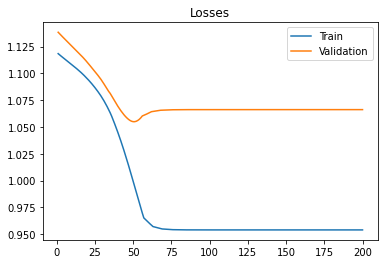

In [148]:
plt.plot([i for i in range(1, EPOCHS_NUM+1)], train_losses, label="Train")
plt.plot([i for i in range(1, EPOCHS_NUM+1)], val_losses, label="Validation")
plt.title("Losses")
plt.legend()
plt.show()

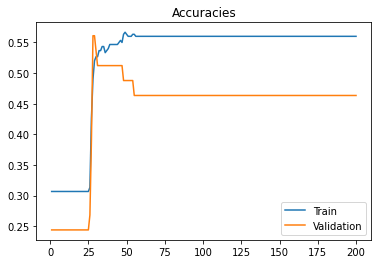

In [118]:
plt.plot([i for i in range(1, EPOCHS_NUM+1)], train_accs, label="Train")
plt.plot([i for i in range(1, EPOCHS_NUM+1)], val_accs, label="Validation")
plt.title("Accuracies")
plt.legend()
plt.show()

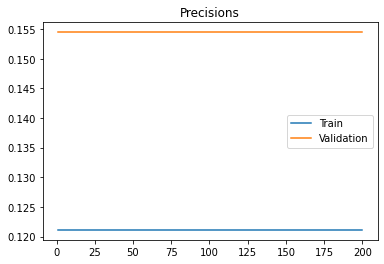

In [109]:
plt.plot([i for i in range(1, EPOCHS_NUM+1)], train_precs, label="Train")
plt.plot([i for i in range(1, EPOCHS_NUM+1)], val_precs, label="Validation")
plt.title("Precisions")
plt.legend()
plt.show()

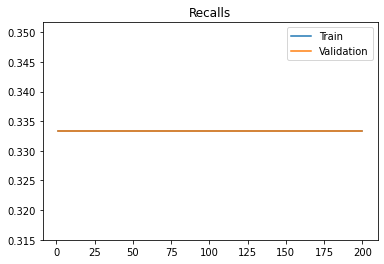

In [110]:
plt.plot([i for i in range(1, EPOCHS_NUM+1)], train_recalls, label="Train")
plt.plot([i for i in range(1, EPOCHS_NUM+1)], val_recalls, label="Validation")
plt.title("Recalls")
plt.legend()
plt.show()

In [89]:
model.load_state_dict(torch.load("./checkpoints/classifier/simple_classifer_clustering.pt",  map_location=device))

<All keys matched successfully>

In [90]:
test_loss = 0
test_acc = 0
test_prec = 0
test_recall = 0
images_count = 0

for images_reps, class_idxs in tqdm(test_dataloader):
        with torch.no_grad():
                images_reps = images_reps.to(device)
                batch_size = images_reps.size()[0]
                class_idxs = class_idxs.squeeze(dim=1).long()
                class_idxs = class_idxs.to(device)
                output = model(images_reps)

                loss = criterion(output, class_idxs)              

                test_loss += loss.item() * batch_size
                images_count += batch_size

                output_labels = torch.argmax(output, dim=1).cpu().detach().numpy()
                class_idxs_np = class_idxs.cpu().numpy()

                batch_accuracy = accuracy_score(class_idxs_np, output_labels)
                batch_precision = precision_score(class_idxs_np, output_labels, average='macro', zero_division=1)
                batch_recall = recall_score(class_idxs_np, output_labels, average='macro', zero_division=1)

                test_acc += batch_accuracy * batch_size
                test_prec += batch_precision * batch_size
                test_recall += batch_recall * batch_size

test_loss = test_loss / images_count
test_acc = test_acc / images_count
test_prec = test_prec / images_count
test_recall = test_recall / images_count

# scheduler.step(val_loss)

print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}, precision: {test_prec:.4f}, recall: {test_recall:.4f}')

100%|██████████| 1/1 [00:00<00:00, 199.90it/s]

Test loss: 1.0310, accuracy: 0.6667, precision: 0.8333, recall: 0.6667
